## Testing algorithms for tweet_data class.

In [1]:
import pandas as pd
def analyse_raw_results(td_object):
    raw_results=td_object.raw_results
    df_all = pd.DataFrame(raw_results,columns=['Z-score','object1','object2'])
    df_all['name1']=[d.name for d in df_all['object1']]
    df_all['name2']=[d.name for d in df_all['object2']]

    df=df_all.loc[:,['Z-score','name1','name2']]
    grouped=df.groupby(['name1','name2'])
    #print([(name,grouped.get_group((name,name))['Z-score'].mean()) for name in set(df['name1'])])
    #grouped_again.get_group('Luke')

#analyse_raw_results(td_to_store)


In [2]:
import poisson_processes as pp
#default_params={'clusters':2,'event probability range':[0.1,0.2],'noise scaling' : 1,'pop_sizes':[5,10]}
def initialise_multiple_populations(length,params):

    #if not 'clusters' in params.keys():
    #    params=default_params
    #print(params.keys())
    clusters=params['clusters']
    mean_lag_range=params['mean lag range']
    event_probability_range=params['event probability range']
    noise_scaling=params['noise scaling']
    max_noise_prob=0.5
    use_fixed_means=params.get('use fixed means')
    
    pop_sizes=np.random.choice(params['pop_sizes'],size=clusters)  
    if clusters < 7:
        pop_names=np.random.choice(['Jill','Rosa','Flo','Luke','Owen','Tom','Elena'],size=clusters,replace=False)
    else:
        pop_names=np.random.choice(list(range(clusters)),size=clusters,replace=False)        
    # set up allowable ranges for events,noise and lag
    ep_lower=event_probability_range[0]
    ep_higher=event_probability_range[1]
    noise_lower=min(ep_lower*noise_scaling,max_noise_prob)
    noise_higher=min(ep_higher*noise_scaling,max_noise_prob)
    lag_lower=mean_lag_range[0]
    lag_upper=mean_lag_range[1]
        
    # initialise event/noise probability and lag values
    event_probs=np.random.uniform(ep_lower,ep_higher,size=clusters)
    mean_lags=np.random.uniform(lag_lower,lag_upper,size=clusters)
    noise_probs=np.random.uniform(noise_lower,noise_higher,size=clusters)
    mpp=pp.initialise_multiple_populations(length=length,sizes=pop_sizes,keys=pop_names,
                                            event_probs=event_probs,mean_lags=mean_lags,noise_probs=noise_probs,
                                           use_fixed_means=use_fixed_means,verbose=False)
        
    ts_obj1=mpp.randomly_mix_populations(pop_names)
    number=len(ts_obj1)        
    ts_obj2=[]
    return number,[ts_obj1,ts_obj2]

Algorithm below initialises dense time series for correlation testing.  If 'use fixed means for setup' is True then the two populations created have expected proportions of entries given by the 'means' dictionary list.  Otherwise each time series within both populations has an expected proportion of entries given by a random selection from a truncated chai-squared distribution.  If poisson_process is true then a poisson process is used to initialise.
The two populations of time series are returned in an array; the known probability from which each individual time series was drawn are stored are also returned as an array 

In [3]:
import time
import numpy as np
import poisson_processes as pp
import pointwise_correlation as pc

def initialise_time_series_matrices(length,number,use_fixed_means_for_setup=True,means=[0.01,0.2],\
                                    poisson_process=False,multiple_populations=False,multiple_pop_params={},verbose=True):
    T=length
    chi_scaling = np.log(10)/np.log(T)
    n=number
    #means_range = max(np.abs(means[0]-means[1]),0.1)
    #means_mean =(means[0]+means[1])/2
    if verbose:
        print("Now initialising externally")
    if use_fixed_means_for_setup:
        print("Initialising with fixed means")
        known_probs_array = [[p for i in range(n)] for p in means]
    else:
        print("Initialising with chi square dist")
        ps=[[chi_scaling*np.random.chisquare(6)/30 for i in range(n)] for j in range(2)]
        known_probs_array=[[p if (p and p<1) else np.random.uniform(min(means),max(means)) for p in vector] for vector in ps]
        
    
    if poisson_process:
        if multiple_populations:
            return initialise_multiple_populations(length,params=multiple_pop_params)
        
        else:
            Y1_betas = [1/p for p in known_probs_array[0]]
            Y2_betas = [1/p for p in known_probs_array[1]]
            if verbose:
                print("Initialising using poisson process")
        #lambdas = {'Y1': {'lambda':Y1_lambdas,'baseline':False},
        #        'Y2': {'lambda':Y2_lambdas,'baseline':False}
        #          }
            pp1 = pp.poisson_process(number = n, length = T, betas = Y1_betas)
            pp2 = pp.poisson_process(number=n,length=T,betas=Y2_betas)
            ts_matrices=[pp1.time_series_objects,pp2.time_series_objects]

                   
        return n,ts_matrices
            
    else:
        tweet_matrices=[[np.random.choice(range(T),size=int(np.random.normal(T*p,np.sqrt(T*p*(1-p)))),replace=False)\
                              for p in vector] for vector in known_probs_array]
        ts_matrices=[[pc.time_series(t_series,known_probs_array[i][j],T)\
                         for j,t_series in enumerate(tweet_matrix)] for i,tweet_matrix in enumerate(tweet_matrices)]

    return n,ts_matrices

In [2]:
print(initialise_time_series_matrices(1000,20,poisson_process =True))

Now initialising externally
Initialising with fixed means
Initialising using poisson process
Initialising for key Y1
Elapsed time: 0.010009527206420898
Initialising for key Y2
Elapsed time: 0.038930416107177734
(array([[array([127, 165, 172, 187, 193, 231, 358, 754, 852, 954]),
        array([ 41, 108, 167, 181, 338, 477, 523, 853, 993]),
        array([ 96, 147, 222, 399, 456, 810, 996]),
        array([ 16,  75, 102, 233, 291, 495, 878, 906, 952]),
        array([267, 500, 639, 684, 877, 881, 898]),
        array([ 91, 182, 534, 566, 703, 711, 740, 836]),
        array([ 15,  35,  41,  83, 136, 169, 234, 278, 345, 359, 372, 401, 502,
       511, 676, 700, 705, 715, 723, 771]),
        array([ 79, 169, 260, 307, 410, 554, 662, 809, 856]),
        array([ 28,  94, 152, 158, 657, 841, 850, 852, 958, 959, 989]),
        array([184, 190, 243, 379, 474, 512, 581, 681, 746, 813, 884, 937, 955]),
        array([ 42, 437, 547, 552, 596, 794, 838, 900, 984]),
        array([  2,  52,  95, 134,

Algorithm tests the two sigma calculations (designated by inferred/known means).   A random set(s) of time series is created (by the tweet_data class method) and correlation z-scores calculated for all pairs of time series.  If disjoint=True, two populations are created and compared pairwise.  If disjoint=False, all pairs within a single population are compared.  Delta is fixed at sqrt(length of time series) but multiple lengths can be passed if required and the test will be carried out for each, with results plotted using both sigma calculations.  Overall results are plotted cumulatively with the final set of graphs contatining all data throughout.

Population means can be fixed in advance (if 'Use fixed means for setup' matches true in the parameter dictionary), or taken from a truncated chai squared distribution if not. 'Use population means is true initially so the later version of sigma is used in this first pass for each length of time series passed.  'Use population means' is then set to false allowing a run on the same data but using each individual time series to estimate the mean in the population from which it was taken.

In [4]:
import time

def compare_inferred_and_known_means(version,xs=[100,200],params={},poisson_process=False,disjoint=True,
                                     multiple_populations=False,multiple_pop_params={},verbose=False,axes=[]):
    """
    *Compares z_scores when means are inferred/known
    *Plot of sigma values for each against length of time series (given by parameter xs) is also shown
    *Number of time series given by parameter number (either in one or both populations)
    *If parameter disjoint is True, two separate populations are tested against each other pairwise
    *If disjoint is False, only one population is tested but all possible pairings are formed
    *If probs are None, individual probabilities are taken from a chai squared distribution
    """
    params_dict = params
    p1 = params_dict['p1']
    p2 = params_dict['p2']
    use_external_initialisation = params_dict['Use external intialisation']
    number=params_dict['n']
    ts=[]
    ys = [] # sigma values for z scores based on inferred means
    zs =[] # mean values for z scores based on inferred means
    y1s=[] # sigma values for z scores based on known population means
    z1s=[] #sigma values for z scores based on known population means
    start_time = time.time()
    
    # start run - for each length of time series (in array xs) correlations are measured for both sigma values
    for T in xs:
        # use maximum delta value
        delta = int(np.sqrt(T)) 
        ts.append(T)        
        print("T is {0}".format(T))

        # set up axes to display results
        f,axes = plt.subplots(2,2)
        f.suptitle("Comparison of inferred v known population means for T = {0},delta = {1}".format(T,delta),fontsize=16)
        for ax in axes[0]:
            ax.plot([0,1],[0,0],'.',alpha=0.2)
        for ax in axes[1]:
            ax.plot([-2,2],[0,0],'.',alpha=0.2)
            
        # initialise time series if using algorithm in notebook
        if use_external_initialisation:
            number,ts_matrices = initialise_time_series_matrices(T,number,use_fixed_means_for_setup=params['Use fixed means for setup'],\
                                                          means=[p1,p2],poisson_process=poisson_process,
                                                        multiple_populations=multiple_populations,multiple_pop_params=multiple_pop_params,verbose=verbose)
            # create time series objects for each time series
            #ts_matrices=[[pc.time_series(tweet_matrices[i][j],known_probs_array[i][j],T) for j in range(number)] 
            #                 for i in range(len(tweet_matrices))]
 
        else:
            ts_matrices = [] # will be initialised within the class
            
        # set parameters and instantiate classes
        params_dict['T'] = T
        params_dict['n'] = number # in case multiple populations have been combined
        if version == pc:
            td = version.tweet_data(ts_matrices,params_dict,delta = delta,
                        disjoint_sets=disjoint,verbose=verbose,axes = [axes[0][0],axes[1][0]])
        #else:
        #    td = version.tweet_data(tweet_matrices=ts_matrices,population_ps = [p1,p2,params_dict],delta = delta,
        #                disjoint_sets=disjoint,verbose=verbose,axes = [axes[0][0],axes[1][0]])
 
        
        print("Running with inferred means.  Time elapsed: {0}".format(time.time()-start_time))        
        td.params['Use population means']=False
        #td.population_ps=[params[0],params[1],params_dict]

        td.display_Z_vals()
        ys.append(np.std(td.results))
        zs.append(np.mean(td.results))
        td_to_store=analyse_raw_results(td)
        
        
        td.params['Use population means']=True
        #td.population_ps=[params[0],params[1],params_dict]
        td.axes=[axes[0][1],axes[1][1]]
        print("Running with population means. Time elapsed: {0}".format(time.time()-start_time))
        
        td.display_Z_vals()
        y1s.append(np.std(td.results))
        z1s.append(np.mean(td.results))
        analyse_raw_results(td)
        #pd.DataFrame(np.transpose([ts,zs,ys,z1s,y1s])).to_csv("{0}/Accumulating results.csv".format(TEMP_DIR))
    
        axes[0][1].errorbar(ts,zs,ys,color='r',label='inferred')
        axes[0][1].errorbar(ts,z1s,y1s,color='b',label='known')
        axes[0][1].set_title("Accumulating results")
        axes[0][1].legend()
        axes[1][0].legend()
        axes[1][1].legend()
        
        plt.show()
    df=pd.concat([pd.DataFrame(xs,columns=['T']),
                   pd.DataFrame(ys,columns=['Z score std dev (inferred means)']),
                   pd.DataFrame(zs,columns=['Z score mean (inferred means)']),
                   pd.DataFrame(y1s,columns=['Z score std dev (known means)']),
                   pd.DataFrame(z1s,columns=['Z score mean (known means)'])],axis=1)
    #df.to_csv("{0}/Sigma_comparison{1}.csv".format(TEMP_DIR,str(xs)[:10]),mode='a')
    return td_to_store,df

The cell below runs the algorithm above, passing the version of the tweet_data class using the 'version' parameter. pointwise_correlation.py code is more streamlined than time_series_correlation.py

T is 1000
Now initialising externally
Initialising with fixed means
Initialising for key Tom_noise
Expected 50 beta values, but only 1 values passed.  Initialising all time series with beta parameter 235.72412704835708
Elapsed time: 0.002991199493408203
Initialising for key Tom
Creating lagging time series population based on single event time series
Now combining poisson processes Tom with Tom_noise
Elapsed time: 0.17655563354492188
Initialising for key Jill_noise
Expected 50 beta values, but only 1 values passed.  Initialising all time series with beta parameter 202.83666731998477
Elapsed time: 0.1785566806793213
Initialising for key Jill
Creating lagging time series population based on single event time series
Now combining poisson processes Jill with Jill_noise
Elapsed time: 0.2842741012573242


For key Tom_noise: From 50 time series length 1000, measured population event probability = 0.0038
Theoretical population mean is 0.0038 with std 0.0

For key Tom: From 50 time series lengt

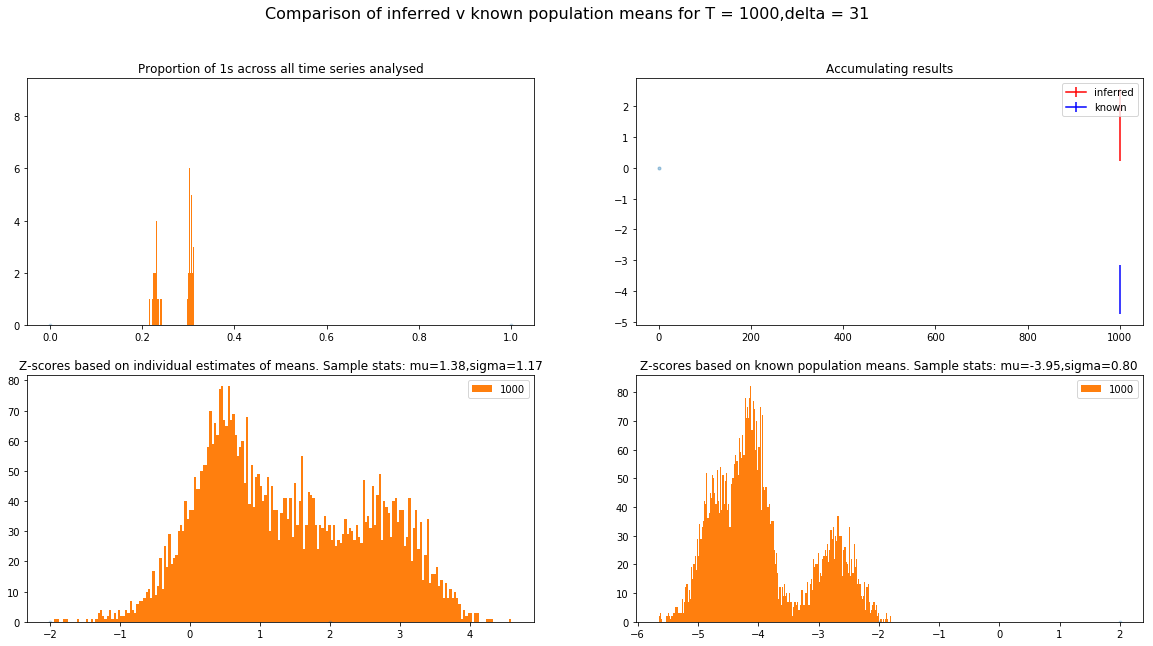

,T,Z score std dev (inferred means),Z score mean (inferred means),Z score std dev (known means),Z score mean (known means)
0,1000,1.170678,1.377713,0.804434,-3.949345


Total of 0 empty time series found
Total of 0 time series calculations ignored (due to fewer than 4 events in one or both)


In [5]:
import pointwise_correlation as pc
import time_series_correlation as tc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize']=[20,10]

pc.SHORT_TIME_SERIES_Z_SCORES = []
pc.EMPTY_TIME_SERIES_COUNT = 0
# parameter dictionary 
params_dict = {
#                'T' : 1000                        # Length of each time series
                'n' : 50,                      # How many time series in each population
               'Use external intialisation' : True,
#               'Use population means' : True, # Refers to whether correlation calculation is based on pre-determined or measured means

                'Use fixed means for setup' : True, # Refers to whether population(s) taken from given means or chai-squared dist
                'p1' : 0.1,
                'p2' : 0.5,            # mean occurences from which populations will be drawn 
    
#               'Test_mode' : False,
#                'dense' : True,  # only needed for time_series_correlation (obsolete class)
                'sparse': False # must be false - only dense time series can be analysed
                    } 

# if combinine multiple populations, these are the parameters for initialising.
multiple_population_params={'clusters':2,'mean lag range' : [2,20],'event probability range':[0.1,0.5],'noise scaling' : 0.01,'pop_sizes':[50]}  
multiple_population_params['use fixed means']=params_dict['Use fixed means for setup']

lengths=[1000]  # Which lengths of time series to run the algorithm for

td_to_store,df=compare_inferred_and_known_means(version=pc,xs=lengths,params=params_dict,
                                    multiple_populations=True,multiple_pop_params=multiple_population_params,
                                    poisson_process=True,disjoint=False,verbose=True)
plt.show()
display(df)

short_ts_data = np.array(pc.SHORT_TIME_SERIES_Z_SCORES)
print("Total of {0} empty time series found".format(pc.EMPTY_TIME_SERIES_COUNT))
print("Total of {0} time series calculations ignored (due to fewer than 4 events in one or both)".format(len(short_ts_data)))

if len(short_ts_data):
    df = pd.DataFrame(list(np.transpose([[min(ts_data[0],ts_data[1]) for ts_data in short_ts_data],list(short_ts_data[:,2])])),
                      columns = ['Length of short time series','Z score'])
    print("Z_scores for comparisons involving very short series averaged : {0}".format(np.mean(short_ts_data[:,2])))
    #plt.plot([min(ts_data[0],ts_data[1]) for ts_data in short_ts_data],short_ts_data[:,2], 'x')
    #plt.show()

#print("Mean and sigma for the z scores for empty time series are {0} and {1}".format(np.mean(z_scores), np.std(z_scores)))
#plt.hist(z_scores)
#print(td_to_store)

In [66]:
print(td_to_store)